In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
movies_df = pd.read_csv('/content/drive/MyDrive/movies.csv',usecols=['movieId','title'],dtype={'movieId': 'int32', 'title': 'str'})
rating_df=pd.read_csv('/content/drive/MyDrive/ratings.csv',usecols=['userId', 'movieId', 'rating'],
    dtype={'userId': 'int32', 'movieId': 'int32', 'rating': 'float32'})

In [ ]:
movies_df.head()

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [ ]:
rating_df.head()

,userId,movieId,rating
0,1,1,4.000
1,1,3,4.000
2,1,6,4.000
3,1,47,5.000
4,1,50,5.000


In [ ]:
df = pd.merge(rating_df,movies_df,on='movieId')
df.head()

,userId,movieId,rating,title
0,1,1,4.000,Toy Story (1995)
1,5,1,4.000,Toy Story (1995)
2,7,1,4.500,Toy Story (1995)
3,15,1,2.500,Toy Story (1995)
4,17,1,4.500,Toy Story (1995)


In [ ]:
combine_movie_rating = df.dropna(axis = 0, subset = ['title'])
movie_ratingCount = (combine_movie_rating.
     groupby(by = ['title'])['rating'].
     count().
     reset_index().
     rename(columns = {'rating': 'totalRatingCount'})
     [['title', 'totalRatingCount']]
    )
movie_ratingCount.head()

,title,totalRatingCount
0,'71 (2014),1
1,'Hellboy': The Seeds of Creation (2004),1
2,'Round Midnight (1986),2
3,'Salem's Lot (2004),1
4,'Til There Was You (1997),2


In [ ]:
rating_with_totalRatingCount = combine_movie_rating.merge(movie_ratingCount, left_on = 'title', right_on = 'title', how = 'left')
rating_with_totalRatingCount.head()

,userId,movieId,rating,title,totalRatingCount
0,1,1,4.000,Toy Story (1995),215
1,5,1,4.000,Toy Story (1995),215
2,7,1,4.500,Toy Story (1995),215
3,15,1,2.500,Toy Story (1995),215
4,17,1,4.500,Toy Story (1995),215


In [ ]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
print(movie_ratingCount['totalRatingCount'].describe())

count   9719.000
mean      10.375
std       22.406
min        1.000
25%        1.000
50%        3.000
75%        9.000
max      329.000
Name: totalRatingCount, dtype: float64


In [ ]:
popularity_threshold = 50
rating_popular_movie= rating_with_totalRatingCount.query('totalRatingCount >= @popularity_threshold')
rating_popular_movie.head()

,userId,movieId,rating,title,totalRatingCount
0,1,1,4.000,Toy Story (1995),215
1,5,1,4.000,Toy Story (1995),215
2,7,1,4.500,Toy Story (1995),215
3,15,1,2.500,Toy Story (1995),215
4,17,1,4.500,Toy Story (1995),215


In [ ]:
rating_popular_movie.shape

(41362, 5)

In [ ]:
## First lets create a Pivot matrix

movie_features_df=rating_popular_movie.pivot_table(index='title',columns='userId',values='rating').fillna(0)
movie_features_df.head()

userId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,570,571,572,573,574,575,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10 Things I Hate About You (1999),0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,5.000,0.000,0.000,0.000,0.000,0.000,0.000,3.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,2.000,0.000,0.000,0.000,0.000,0.000,0.000,5.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.000,0.000,3.000,3.000,0.000,0.000,3.000,0.000,5.000,0.000,0.000,0.000,0.000,0.000
12 Angry Men (1957),0.000,0.000,0.000,5.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,4.000,0.000,5.000,0.000,0.000,0.000,0.000,3.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,4.000,0.000,0.000,0.500,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,5.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,5.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2001: A Space Odyssey (1968),0.000,0.000,0.000,0.000,0.000,0.000,4.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,4.000,3.000,0.000,0.000,0.000,4.000,0.000,0.000,0.000,2.000,3.000,5.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2.000,0.000,...,0.000,0.000,5.000,0.000,0.000,0.000,3.000,0.000,0.000,3.500,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,5.000,0.000,0.000,0.000,0.000,0.000,4.000,0.000,0.000,5.000,4.000,0.000,0.000,5.000,0.000,0.000,5.000,0.000,3.000,0.000,4.500
28 Days Later (2002),0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.500,0.000,0.000,0.000,0.000,0.000,0.000,1.500,0.000,0.000,0.000,0.000,0.000,3.000,4.500,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,4.500,0.000,0.000,0.000,0.000,0.000,4.500,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,4.000,0.000,0.000,3.000,3.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.500,0.000,5.000
300 (2007),0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.500,0.000,0.000,3.500,0.000,0.000,4.000,0.000,0.000,0.000,4.500,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,4.500,0.000,0.000,0.000,0.000,0.000,5.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.500,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.000,0.000,0.000,0.000,0.000,0.000,3.000,0.000,0.000,5.000,0.000,4.000


In [ ]:
from scipy.sparse import csr_matrix

movie_features_df_matrix = csr_matrix(movie_features_df.values)

from sklearn.neighbors import NearestNeighbors


model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(movie_features_df_matrix)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [ ]:
movie_features_df.shape

(450, 606)

In [ ]:
query_index = np.random.choice(movie_features_df.shape[0])
print(query_index)
distances, indices = model_knn.kneighbors(movie_features_df.iloc[query_index,:].values.reshape(1, -1), n_neighbors = 6)

17


In [ ]:
movie_features_df.head()

userId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,570,571,572,573,574,575,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10 Things I Hate About You (1999),0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,5.000,0.000,0.000,0.000,0.000,0.000,0.000,3.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,2.000,0.000,0.000,0.000,0.000,0.000,0.000,5.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.000,0.000,3.000,3.000,0.000,0.000,3.000,0.000,5.000,0.000,0.000,0.000,0.000,0.000
12 Angry Men (1957),0.000,0.000,0.000,5.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,4.000,0.000,5.000,0.000,0.000,0.000,0.000,3.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,4.000,0.000,0.000,0.500,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,5.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,5.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2001: A Space Odyssey (1968),0.000,0.000,0.000,0.000,0.000,0.000,4.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,4.000,3.000,0.000,0.000,0.000,4.000,0.000,0.000,0.000,2.000,3.000,5.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2.000,0.000,...,0.000,0.000,5.000,0.000,0.000,0.000,3.000,0.000,0.000,3.500,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,5.000,0.000,0.000,0.000,0.000,0.000,4.000,0.000,0.000,5.000,4.000,0.000,0.000,5.000,0.000,0.000,5.000,0.000,3.000,0.000,4.500
28 Days Later (2002),0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.500,0.000,0.000,0.000,0.000,0.000,0.000,1.500,0.000,0.000,0.000,0.000,0.000,3.000,4.500,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,4.500,0.000,0.000,0.000,0.000,0.000,4.500,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,4.000,0.000,0.000,3.000,3.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.500,0.000,5.000
300 (2007),0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.500,0.000,0.000,3.500,0.000,0.000,4.000,0.000,0.000,0.000,4.500,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,4.500,0.000,0.000,0.000,0.000,0.000,5.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.500,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.000,0.000,0.000,0.000,0.000,0.000,3.000,0.000,0.000,5.000,0.000,4.000


In [ ]:
for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for {0}:\n'.format(movie_features_df.index[query_index]))
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, movie_features_df.index[indices.flatten()[i]], distances.flatten()[i]))

Recommendations for Amadeus (1984):

1: Apocalypse Now (1979), with distance of 0.45913296937942505:
2: Stand by Me (1986), with distance of 0.5234026908874512:
3: Rain Man (1988), with distance of 0.5318436026573181:
4: Fargo (1996), with distance of 0.5378233194351196:
5: Citizen Kane (1941), with distance of 0.5386159420013428:


In [ ]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(movie_features_df_matrix)

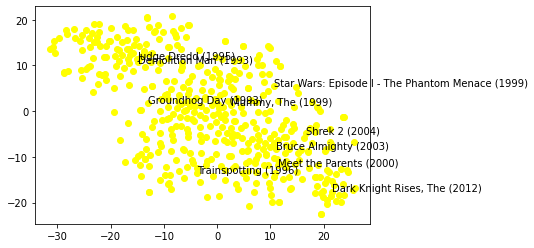

In [ ]:
import matplotlib.pyplot as plt
import random
plt.scatter(X_embedded[:,0],X_embedded[:,1],c='yellow')
for i in range(10):
  x=random.randint(0,450)
  plt.annotate(movie_features_df.index[x],(X_embedded[x,0],X_embedded[x,1]))